In [826]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# pd.set_option("max_rows", None)

In [827]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://homl.info/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic:
            titanic.extractall(path="datasets")
    return pd.read_csv(Path("datasets/titanic/train.csv")), pd.read_csv(Path("datasets/titanic/test.csv"))

train, test = load_housing_data()

In [828]:
train_passengers = train['PassengerId']
test_passengers = test['PassengerId']
test['Survived'] = np.NaN
total = pd.concat([train, test])
total.set_index('PassengerId', inplace=True)

In [829]:
X_train = total.copy()
y_train = X_train['Survived']
X_train = X_train.drop('Survived', axis=1)
# X_train.set_index('PassengerId', inplace=True)
# X_test = test.copy()
# X_test.set_index('PassengerId', inplace=True)

In [830]:
# fill average ages for nan value
X_train['Age'] = X_train['Age'].fillna(X_train['Age'].mean())
# drop the row with the empty value in the column Embarked
# X_train.dropna(subset='Embarked', axis=0, inplace=True)
# drop the row where Fare is equal to 0
# X_train = X_train[X_train['Fare']!=0]
X_train['Name_transformed'] = X_train['Name'].apply(
    lambda x: x.split('.')[0].split(',')[-1].strip()
)
X_train['marriage_status'] = X_train['Name_transformed'].map({'Mrs':' married'})
X_train['marriage_status'] = X_train['marriage_status'].fillna('unknown')
X_train.drop(['Name', 'Ticket'], axis=1, inplace=True)
X_train['Has_SibSp'] = X_train['SibSp'].apply(lambda x: True if x>0 else False)
X_train['Has_Parch'] = X_train['Parch'].apply(lambda x: True if x>0 else False)
# X_train['Carbin_area'] = X_train['Cabin'].apply(lambda x: str(x)[0].lower() if pd.notna(x) else 'Unknown')
# drop the column Cabin
X_train.drop('Cabin', axis=1, inplace=True)

In [831]:
# before scaling numeric features, log them first
# only Fare's distribution is heavily long tailed

from sklearn.preprocessing import FunctionTransformer
log_cols = ['Fare']
X_train[log_cols] = X_train[log_cols] + 1 # plus one to avoid zero divided error
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(X_train[log_cols])
X_train[log_cols] = log_pop

array([[<AxesSubplot:title={'center':'Fare'}>]], dtype=object)

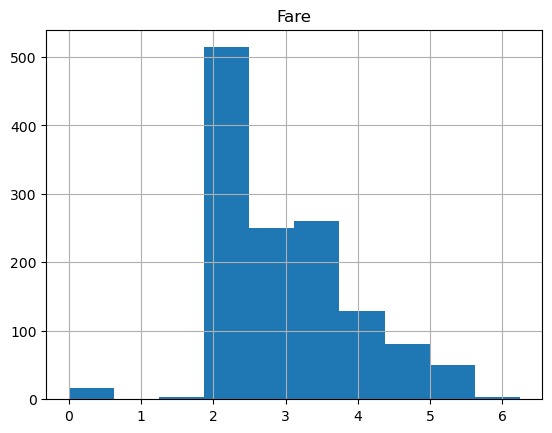

In [832]:
# Fare distribution after log
X_train[log_cols].hist()

In [833]:
X_train['Age'].info()

<class 'pandas.core.series.Series'>
Int64Index: 1309 entries, 1 to 1309
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
1309 non-null   float64
dtypes: float64(1)
memory usage: 20.5 KB


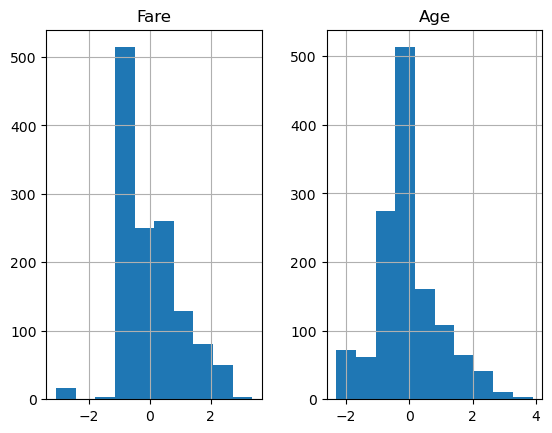

In [834]:
# Scale features

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
std_cols = ['Fare', 'Age']
std_fare = std_scaler.fit_transform(X_train[std_cols])
pd.DataFrame(std_fare, columns=std_cols).hist(bins=10)
X_train[std_cols] = pd.DataFrame(std_fare, columns=std_cols, index=X_train.index)

In [835]:
pd.DataFrame(std_fare, columns=std_cols).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fare    1308 non-null   float64
 1   Age     1309 non-null   float64
dtypes: float64(2)
memory usage: 20.6 KB


In [836]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Pclass            1309 non-null   int64  
 1   Sex               1309 non-null   object 
 2   Age               1309 non-null   float64
 3   SibSp             1309 non-null   int64  
 4   Parch             1309 non-null   int64  
 5   Fare              1308 non-null   float64
 6   Embarked          1307 non-null   object 
 7   Name_transformed  1309 non-null   object 
 8   marriage_status   1309 non-null   object 
 9   Has_SibSp         1309 non-null   bool   
 10  Has_Parch         1309 non-null   bool   
dtypes: bool(2), float64(2), int64(3), object(4)
memory usage: 104.8+ KB


In [838]:
# one hot code for two categories columns
from sklearn.preprocessing import OneHotEncoder

col_encoder = ['Sex', 'Embarked', 'marriage_status','Has_SibSp', 'Has_Parch', 'Pclass']
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
ohe_data = ohe.fit_transform(X_train[col_encoder])

df_encoder = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(),
                          index=X_train.index)

X_train = X_train.join(df_encoder)
X_train.drop(col_encoder, axis=1, inplace=True)

In [ ]:
X_train.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Name_transformed', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Embarked_nan',
       'marriage_status_ married', 'marriage_status_unknown',
       'Has_SibSp_False', 'Has_SibSp_True', 'Has_Parch_False',
       'Has_Parch_True', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Carbin_area_Unknown', 'Carbin_area_a', 'Carbin_area_b',
       'Carbin_area_c', 'Carbin_area_d', 'Carbin_area_e', 'Carbin_area_f',
       'Carbin_area_g', 'Carbin_area_t'],
      dtype='object')

In [839]:
input_cols = [ 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'Sex_female', 
                         'Sex_male']
X_train_model = X_train.loc[train_passengers,input_cols]
y_train_model = y_train[train_passengers]

In [840]:
y_train_model.value_counts()

0.0    549
1.0    342
Name: Survived, dtype: int64

## Random Forest

In [885]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1,n_estimators=100, max_depth=5)
forest_clf.fit(X_train_model, y_train_model)
X_pred = forest_clf.predict(X_train_model)
# final_rmse = mean_squared_error(y_train_model, X_pred, squared=False)
# final_rmse

In [887]:
cross_val_score(forest_clf, X_train_model, y_train_model, cv=15, scoring="accuracy").mean()

0.7934274952919019

In [883]:
# from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score

# y_probas_forest = cross_val_predict(forest_clf, X_train_model, y_train_model, cv=3, method='predict_proba', n_jobs=-1)
# y_scores_forest = y_probas_forest[:, 1]
# precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_model, y_scores_forest)
# plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
# plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
# plt.ylabel("recalls")
# plt.xlabel("precision")

In [845]:
y_train_pred_forest = y_probas_forest[:, 1] > 0.45
f1_score(y_train_model, y_train_pred_forest)

0.7409551374819102

In [888]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_model, y_train_pred_forest)
cm

array([[535,  14],
       [171, 171]])

In [847]:
ids = 1
false_positive = []
false_negative = []
for i, j in zip(y_train_model,y_train_pred_forest):
    if i == 1 and j == 0 and i != j:
        false_negative.append(ids)
    if i == 0 and j == 1 and i != j:
        false_positive.append(ids)
    ids += 1


In [848]:
len(false_negative)

86

In [849]:
#false negative
X_train_FN = train[train['PassengerId'].isin(false_negative)]
X_train_FN

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
25,26,1,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.0,1,5,347077,31.3875,NaN,S
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S
...,...,...,...,...,...,...,...,...,...,...,...,...
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
857,858,1,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,E17,S
866,867,1,2,"Duran y More, Miss. Asuncion",female,27.0,1,0,SC/PARIS 2149,13.8583,NaN,C
869,870,1,3,"Johnson, Master. Harold Theodor",male,4.0,1,1,347742,11.1333,NaN,S


<AxesSubplot:>

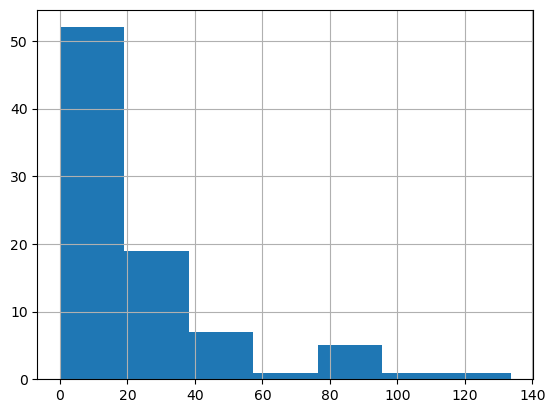

In [850]:
X_train_FN['Fare'].hist(bins=7)
# plt.title = "false negative"

In [851]:
#false positive
X_train_FP = train[train['PassengerId'].isin(false_positive)]
X_train_FP
# X_train_FP['Pclass'].hist()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.0,0,0,350406,7.8542,NaN,S
18,19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,1,0,345763,18.0000,NaN,S
33,34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,NaN,S
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C
35,36,0,1,"Holverson, Mr. Alexander Oskar",male,42.0,1,0,113789,52.0000,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
888,889,0,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [853]:
max = {'f1_score': [], 'roc_auc_score': []}
f1_max, roc_auc_max = 0, 0
for i in range(0,10, 1):
    i = i/10
    y_train_pred_forest = y_probas_forest[:, 1] > i
    f1 = f1_score(y_train_model, y_train_pred_forest)
    if f1 > f1_max:
       max['f1_score'] = [f1, i] 
       f1_max = f1
    roc_auc = roc_auc_score(y_train_model, y_scores_forest)
    if roc_auc > roc_auc_max:
       max['roc_auc_score'] = [roc_auc, i] 
       roc_auc_max = roc_auc

In [854]:
max

{'f1_score': [0.7338345864661654, 0.5],
 'roc_auc_score': [0.8310937483356236, 0.0]}

In [855]:
roc_auc_score(y_train_model, y_scores_forest)

0.8310937483356236

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score()

In [856]:
from sklearn.model_selection import cross_val_score,cross_val_predict

tree_rmses = cross_val_score(forest_clf, X_train_model, y_train_model,
                              scoring="accuracy", cv=5, n_jobs=-1, )
tree_rmses

array([0.75418994, 0.80337079, 0.80898876, 0.8258427 , 0.80898876])

In [889]:
y_test_pred1 = forest_clf.predict(X_train.loc[test_passengers,input_cols])

In [890]:
output1 = pd.DataFrame(y_test_pred1.reshape(-1,1), columns=['Survived'], index=test_passengers)
output1 = output1.astype('int8')
output1.to_csv('gender_submission.csv')

In [892]:
output1.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


## LinearRegression
Linear Regaression has 0.76555 scores which is higher than Random Forest
* need to understand why?

In [859]:
from sklearn.linear_model import LinearRegression

linReg_clf = LinearRegression(n_jobs=-1)
linReg_clf.fit(X_train_model, y_train_model)
X_pred = linReg_clf.predict(X_train_model)
final_rmse = mean_squared_error(y_train_model, X_pred, squared=False)
final_rmse

0.3819076958274173

In [860]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(linReg_clf, X_train_model, y_train_model,
                              scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
tree_rmses.mean()

0.3845605396887368

In [861]:
y_test_pred2 = linReg_clf.predict(X_train.loc[test_passengers,[ 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'Sex_female', 
                         'Sex_male']])

In [862]:
output2 = pd.DataFrame(y_test_pred2.reshape(-1,1), columns=['Survived'], index=test_passengers)
output2['Survived'] = output2['Survived'].round().astype('int')
output2.to_csv('gender_submission.csv')

## SGD

In [863]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, n_jobs=-1)
sgd_clf.fit(X_train_model, y_train_model)


SGDClassifier(n_jobs=-1, random_state=42)

In [882]:
cross_val_score(sgd_clf, X_train_model, y_train_model, cv=15, scoring="accuracy").mean()

0.7510922787193972

In [865]:
from sklearn.model_selection import cross_val_predict

y_train_model_pred = cross_val_predict(sgd_clf, X_train_model, y_train_model, cv=4)

In [866]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_model, y_train_model_pred)
cm

array([[444, 105],
       [111, 231]])

In [867]:
f1_score(y_train_model, y_train_model_pred)

0.6814159292035398

In [873]:
y_test_pred2 = sgd_clf.predict(X_train.loc[test_passengers,input_cols])

In [874]:
output2 = pd.DataFrame(y_test_pred2.reshape(-1,1), columns=['Survived'], index=test_passengers)
output2['Survived'] = output2['Survived'].round().astype('int')
output2.to_csv('gender_submission.csv')

## Dummy Classification

In [868]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(random_state=42)
dummy_clf.fit(X_train_model, y_train_model)

DummyClassifier(random_state=42)

In [869]:
cross_val_score(dummy_clf, X_train_model, y_train_model, cv=4, scoring="accuracy")

array([0.61883408, 0.61434978, 0.61434978, 0.61711712])

In [870]:
# from sklearn.base import BaseEstimator, TransformerMixin
# class columnDropperTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self,columns):
#         self.columns=columns

#     def transform(self,X,y=None):
#         return X.drop(self.columns,axis=1)

#     def fit(self, X, y=None):
#         return self 

In [871]:
# from sklearn.pipeline import Pipeline

# cleansing_pipeline = (
#     [
#     ("dropColumns", columnDropperTransformer(columns="Age")),
#     ("fill na", SimpleImputer(strategy="median"))
#     ]
# )